## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This fully quantum approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions.

This implementation uses aer_simulator_statevector.

Additionally, this code includes amplitude encoding method to map classical data (gray gradient images) into quantum states.

## Implementation (statevector simulation + amlitude encoding)

In [49]:
# INSTALATION INSTRUCTIONS

# For linux 64-bit systems,
#uname -a

# Conda quick installation
#mkdir -p ~/miniconda3
#wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
#bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
#rm ~/miniconda3/miniconda.sh

# Create enviroment with conda
#conda create -n myenv python=3.10
#conda activate myenv
#pip install qiskit==1.4.3 qiskit-machine-learning==0.8.2 'qiskit-machine-learning[sparse]' tensorflow tensorflow-datasets matplotlib pylatexenc ipykernel
# IMPORTANT: Make sure you are on 3.10
# May need to restart the kernel after instalation

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, StatePreparation
from qiskit.primitives import StatevectorEstimator
from qiskit.visualization import plot_histogram

from qiskit_machine_learning.neural_networks import EstimatorQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import copy
import matplotlib.pyplot as plt
import time
import os

2025-07-07 23:31:00.580448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751923860.606084    7940 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751923860.613933    7940 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751923860.636094    7940 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751923860.636128    7940 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751923860.636132    7940 computation_placer.cc:177] computation placer alr

In [7]:
# Number of qubits
N_QUBITS = 4

SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

draw_circuits = 1
draw_prob = 0
draw_images = 1
print_progress = 1

In [52]:
# # Load tensorflow dataset
# batch_size = 1
# dataset_name = 'binary_alpha_digits'
# n_samples = 1000

# X, X_info = tfds.load(
#     dataset_name,
#     split='train[:' + str(n_samples) + ']',
#     batch_size=batch_size,
#     shuffle_files=True,
#     with_info=True
# )

# X = X.shuffle(
#     buffer_size=n_samples,
#     seed=SEED, 
#     reshuffle_each_iteration=True
#     )
# #resize
# #gray

# x = next(iter(X)) #.numpy()?

# image = x["image"]
# for i in range(batch_size):
#     plt.subplot(1, batch_size, i+1)
#     plt.imshow(tf.squeeze(image[i]), cmap="gray")
#     plt.axis("off")
# plt.show()

In [ ]:
# Create real data sample circuit
def generate_real_circuit(matrix):
        qc = QuantumCircuit(N_QUBITS)
        qc.prepare_state(state=matrix.flatten(),
                         qubits=qc.qubits,
                         normalize=True)
        return qc

In [5]:
# Build my own dataset of images: gradient images
def apply_curve(x, curve):
    if curve == 'linear':
        return x
    elif curve == 'quadratic':
        return x ** 2
    elif curve == 'sqrt':
        return np.sqrt(x)
    elif curve == 'log':
        return np.log1p(x * 9) / np.log(10)  # scale [0,1] into [0,1] log space
    elif curve == 'exp':
        return (np.exp(x * 3) - 1) / (np.exp(3) - 1)  # normalized exponential
    elif curve == 'sigmoid':
        return 1 / (1 + np.exp(-10 * (x - 0.5)))  # smooth S-curve
    elif curve == 'sin':
        return 0.5 * (1 - np.cos(np.pi * x))  # smooth start and end
    else:
        raise ValueError(f"Unknown curve type: {curve}")

def create_gradients(total_pixels, directions=None, curves=None, width=None, height=None):
    if directions is None:
        directions = [
            'top_left_to_bottom_right'
        ]
    if curves is None:
        curves = ['linear', 'quadratic', 'sqrt', 'log', 'exp', 'sigmoid', 'sin']

    if width is None or height is None:
        for h in range(int(np.sqrt(total_pixels)), 0, -1):
            if total_pixels % h == 0:
                width, height = total_pixels // h, h
                break
    elif width * height != total_pixels:
        raise ValueError("Provided width and height do not match total number of pixels.")

    max_val = 255
    gradients = []

    i, j = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

    # Precompute normalized coordinate matrices for all directions
    norm_maps = {
        'left_to_right': np.tile(np.linspace(0, 1, width), (height, 1)),
        'right_to_left': np.tile(np.linspace(1, 0, width), (height, 1)),
        'top_to_bottom': np.tile(np.linspace(0, 1, height)[:, np.newaxis], (1, width)),
        'bottom_to_top': np.tile(np.linspace(1, 0, height)[:, np.newaxis], (1, width)),
        'top_left_to_bottom_right': (i + j) / (width + height - 2),
        'bottom_right_to_top_left': ((height - 1 - i) + (width - 1 - j)) / (width + height - 2),
        'top_right_to_bottom_left': (i + (width - 1 - j)) / (width + height - 2),
        'bottom_left_to_top_right': ((height - 1 - i) + j) / (width + height - 2)
    }

    for direction in directions:
        if direction not in norm_maps:
            raise ValueError(f"Unknown direction: {direction}")
        base_map = norm_maps[direction]

        for curve in curves:
            # Apply curve to normalized map
            curved_map = apply_curve(base_map, curve)
            gradients.append(curved_map)

    return gradients, (height, width)

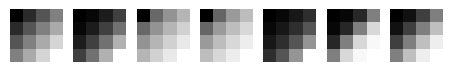

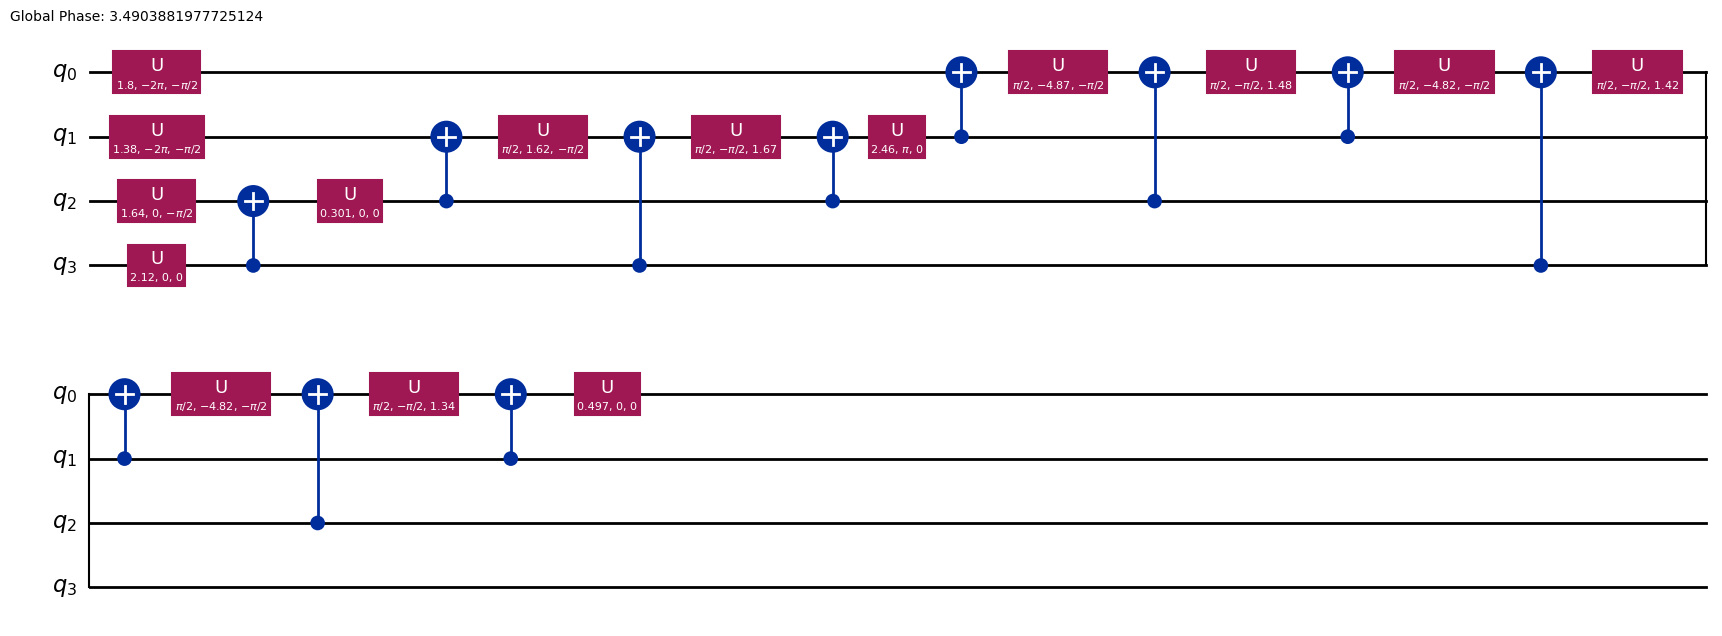

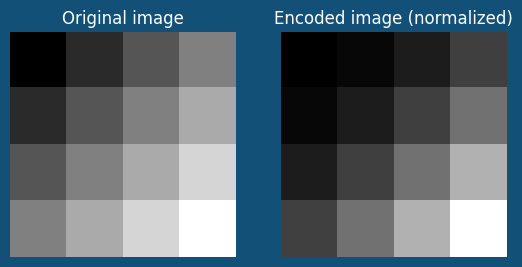

In [ ]:
# Load dataset and show an example
X, dims = create_gradients(2**N_QUBITS)

for i in range(len(X)):
    plt.subplot(1,len(X)+1,i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis("off")
plt.show()

real_sample = X[0] # Example sample. Number of features must be a positive power of 2
real_circuit = generate_real_circuit(real_sample)

if draw_circuits:
    display(real_circuit.decompose(reps=4).draw('mpl'))

if draw_prob:
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**N_QUBITS):
                key = format(n, 'b').zfill(N_QUBITS)
                if key not in dict.keys():
                    dict[key] = 0.0

    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    prepare_dicts([real_prob_dict])
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1.set_title("Real data distribution sample")
    plot_histogram(real_prob_dict, ax=ax1)
    plt.show()

if draw_images:
    plt.subplot(1,2,1)
    plt.imshow(real_sample, cmap="gray")
    plt.axis("off")
    plt.title("Original image", color="white")

    probs = np.array(Statevector(real_circuit).probabilities()).reshape(dims)
    plt.subplot(1,2,2)
    plt.imshow(probs, cmap="gray")
    plt.axis("off")
    plt.title("Encoded image (normalized)", color="white")
    plt.gca().set_facecolor("#135077ff")

    # Optionally set the overall figure background to black
    plt.gcf().patch.set_facecolor("#135077ff")

    plt.show()

In [56]:
# Create generator
def generate_generator():
    qc = RealAmplitudes(N_QUBITS,
                        entanglement="reverse_linear",
                        reps=3, # Number of layers
                        parameter_prefix='θ_g',
                        name='Generator')
    return qc


generator = generate_generator()


if draw_circuits:
    display(generator.decompose().draw('mpl'))

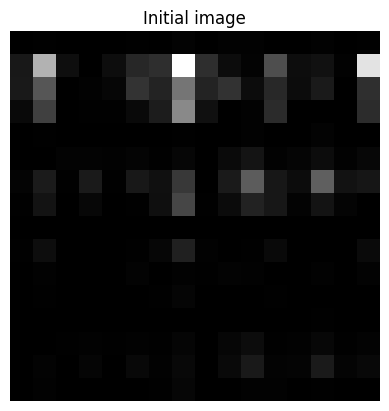

32

In [57]:
# Initialize generator parameters
N_GPARAMS = generator.num_parameters

init_gen_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_GPARAMS,))

if draw_prob:
    init_gen_circuit = generator.assign_parameters(init_gen_params)
    init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial distribution")
    plot_histogram(init_prob_dict, ax=ax1)

if draw_images:
    init_gen_circuit = generator.assign_parameters(init_gen_params)
    probs = np.array(Statevector(init_gen_circuit).probabilities()).reshape(dims)
    plt.subplot(1,1,1)
    plt.imshow(probs, cmap="gray")
    plt.axis("off")
    plt.title("Initial image")
    plt.show()

N_GPARAMS

In [58]:
# Create discriminator
def generate_discriminator():
    qc = EfficientSU2(N_QUBITS,
                      entanglement="reverse_linear",
                      reps=1, # Number of layers
                      parameter_prefix='θ_d',
                      name='Discriminator')

    qc_n_p = qc.num_parameters
    disc_weights = ParameterVector('θ_d', qc_n_p + 2)

    param_index = qc_n_p

    for i in reversed(range(N_QUBITS - 1)):
        qc.cx(i, N_QUBITS - 1)

    #qc.rx(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.ry(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.rz(disc_weights[param_index], N_QUBITS-1); param_index += 1
    
    return qc


discriminator = generate_discriminator()


if draw_circuits:
    display(discriminator.draw('mpl'))
    

In [59]:
# Initialize generator parameters
N_DPARAMS = discriminator.num_parameters

init_disc_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_DPARAMS,))

N_DPARAMS

34

In [60]:
# Set up training quantum circuits
def generate_training_circuits():
    # Connect real data and discriminator
    real_disc_circuit = QuantumCircuit(N_QUBITS)
    real_disc_circuit.compose(real_circuit, inplace=True)
    real_disc_circuit.compose(discriminator, inplace=True)

    # Connect generator and discriminator
    gen_disc_circuit = QuantumCircuit(N_QUBITS)
    gen_disc_circuit.compose(generator, inplace=True)
    gen_disc_circuit.compose(discriminator, inplace=True)

    # Use EstimatorQNN to compile the circuit and handle gradient calculation
    estimator = StatevectorEstimator()

    gradient = ParamShiftEstimatorGradient(estimator=estimator)

    H1 = SparsePauliOp.from_list([("Z" + "I"*(N_QUBITS-1), 1.0)])

    # specify QNN to update generator parameters
    gen_qnn = EstimatorQNN(circuit=gen_disc_circuit,
                        input_params=gen_disc_circuit.parameters[:N_DPARAMS], # fixed parameters (discriminator parameters)
                        weight_params=gen_disc_circuit.parameters[N_DPARAMS:], # parameters to update (generator parameters)
                        estimator=estimator,
                        observables=[H1],
                        gradient=gradient,
                        default_precision=0.0
                        )

    # specify QNN to update discriminator parameters regarding to fake data
    disc_fake_qnn = EstimatorQNN(circuit=gen_disc_circuit,
                            input_params=gen_disc_circuit.parameters[N_DPARAMS:], # fixed parameters (generator parameters)
                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS], # parameters to update (discriminator parameters)
                            estimator=estimator,
                            observables=[H1],
                            gradient=gradient,
                            default_precision=0.0
                            )

    # specify QNN to update discriminator parameters regarding to real data
    disc_real_qnn = EstimatorQNN(circuit=real_disc_circuit,
                            input_params=[], # no input parameters
                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS], # parameters to update (discriminator parameters)
                            estimator=estimator,
                            observables=[H1],
                            gradient=gradient,
                            default_precision=0.0
                            )
    
    return gen_qnn, disc_fake_qnn, disc_real_qnn

gen_qnn, disc_fake_qnn, disc_real_qnn = generate_training_circuits()

In [61]:
# Initialize Adam optimizer from Keras (TensorFlow)
def generate_optimizers(reset, optimizers_data_folder, gen_params, disc_params):
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    # Create optimizer training state checkpoints
    ckpt = tf.train.Checkpoint(
        generator_vars=gen_params,
        discriminator_vars=disc_params,
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer
    )
    ckpt_manager = tf.train.CheckpointManager(ckpt, optimizers_data_folder, max_to_keep=3)
    if reset:
        ckpt_manager.save()
    else:
        ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()

    return generator_optimizer, discriminator_optimizer, ckpt_manager

In [62]:
# Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [63]:
def manage_files(data_folder_name="data", implementation_name="fullyq", training_data_file_name='training_data', parameter_data_file_name='parameters', optimizers_data_folder_name='optimizer'):
    data_folder = data_folder_name + '/' + implementation_name + '/' + "sim-amp" + '/' + 'q' + str(N_QUBITS) + '/' + 'seed' + str(SEED) + '/' 
    training_data_file = data_folder + training_data_file_name + '.txt'
    parameter_data_file = data_folder + parameter_data_file_name + '.txt'
    optimizers_data_folder = data_folder + optimizers_data_folder_name + '/'

    # Create data folder if it does not exist
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    return training_data_file, parameter_data_file, optimizers_data_folder
    

In [64]:
def initialize_parameters(reset, training_data_file, parameter_data_file):
    if reset == 1:
        current_epoch = 0
        gloss, dloss, kl_div = [], [], []

        np.random.seed(SEED)
        init_gen_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_GPARAMS,))
        init_disc_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_DPARAMS,))
        gen_params = tf.Variable(init_gen_params)
        disc_params = tf.Variable(init_disc_params)
        best_gen_params = tf.Variable(init_gen_params)

        # Reset data files
        with open(training_data_file, 'w') as file:
            pass
        with open(parameter_data_file, 'w') as file:
            file.write(str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
            
    else:
        # Load training data
        try:
            with open(training_data_file) as f:
                lines = f.read().splitlines()
        except FileNotFoundError:
            print("Training data file not found. Resetting parameters.")
            return initialize_parameters(1, training_data_file, parameter_data_file)
        current_epoch = len(lines)
        gloss, dloss, kl_div = [], [], []
        for line in lines:
            line_data = line.split(";")
            if len(line_data) != 4:
                raise Exception("ERROR: Wrong data length in training_data.txt file in line:", line, ". Please, reset data.")
            gloss.append(np.float64(line_data[1]))
            dloss.append(np.float64(line_data[2]))
            kl_div.append(np.float64(line_data[3]))

        # Load parameters
        with open(parameter_data_file) as f: # Load parameters
            line = f.readline()
        line_data = line.split(";")
        if len(line_data) != 5:
            raise Exception("ERROR: Wrong number of parameters in parameters.txt file. Please, reset data.")
        init_gen_params = np.array(eval(line_data[0])).astype(float)
        init_disc_params = np.array(eval(line_data[1])).astype(float)
        gen_params = tf.Variable(np.array(eval(line_data[2])).astype(float))
        disc_params = tf.Variable(np.array(eval(line_data[3])).astype(float))
        best_gen_params = tf.Variable(np.array(eval(line_data[4])).astype(float))

    return current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params

In [46]:
# Training

#--- Initialize parameters ---#
max_epoch = 1000
reset = 0 # Reset data

training_data_file, parameter_data_file, optimizers_data_folder = manage_files()

current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params = initialize_parameters(reset, training_data_file, parameter_data_file)


#--- Create and load optimizer states ---#
generator_optimizer, discriminator_optimizer, optimizers_ckpt_manager = generate_optimizers(reset, optimizers_data_folder, gen_params, disc_params)


D_STEPS = 1
G_STEPS = 1
C_STEPS = 1
if print_progress:
    TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
    print(TABLE_HEADERS)
file = open(training_data_file,'a')
start_time = time.time()

#--- Training loop ---#
try: # In case of interruption
    for epoch in range(current_epoch, max_epoch+1):

        #--- Quantum discriminator parameter updates ---#
        for disc_train_step in range(D_STEPS):
            # Calculate discriminator cost
            if (disc_train_step % D_STEPS == 0) and (epoch % C_STEPS == 0):
                value_dcost_fake = disc_fake_qnn.forward(gen_params, disc_params)[0,0]
                value_dcost_real = disc_real_qnn.forward([], disc_params)[0,0]
                disc_loss = ((value_dcost_real - value_dcost_fake)-2)/4
                dloss.append(disc_loss)

            # Caltulate discriminator gradient
            grad_dcost_fake = disc_fake_qnn.backward(gen_params, disc_params)[1][0,0]
            grad_dcost_real = disc_real_qnn.backward([], disc_params)[1][0,0]
            grad_dcost = grad_dcost_real - grad_dcost_fake
            grad_dcost = tf.convert_to_tensor(grad_dcost)
            
            # Update discriminator parameters
            discriminator_optimizer.apply_gradients(zip([grad_dcost], [disc_params]))

        #--- Quantum generator parameter updates ---#
        for gen_train_step in range(G_STEPS):
            # Calculate generator cost
            if (gen_train_step % G_STEPS == 0) and (epoch % C_STEPS == 0):
                value_gcost = gen_qnn.forward(disc_params, gen_params)[0,0]
                gen_loss = (value_gcost-1)/2
                gloss.append(gen_loss)

            # Calculate generator gradient
            grad_gcost = gen_qnn.backward(disc_params, gen_params)[1][0,0]
            grad_gcost = tf.convert_to_tensor(grad_gcost)

            # Update generator parameters
            generator_optimizer.apply_gradients(zip([grad_gcost], [gen_params]))

        #--- Track KL and save best performing generator weights ---#
        gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy())
        gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict() # Retrieve probability distribution of generator with current parameters
        
        real_prob_dict = Statevector(real_circuit).probabilities_dict() # Retrieve real data probability distribution
        
        current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
        kl_div.append(current_kl)
        if np.min(kl_div) == current_kl:
            best_gen_params = copy.deepcopy(gen_params) # New best

        #--- Save progress in file ---#
        file.write(str(epoch) + ";" + str(gloss[-1]) + ";" + str(dloss[-1]) + ";" + str(kl_div[-1]) + "\n")

        #--- Print progress ---#
        if print_progress and (epoch % 10 == 0):
            for header, val in zip(TABLE_HEADERS.split('|'),
                                (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                print(f"{val:.3g} ".rjust(len(header)), end="|")
            start_time = time.time()
            print()
            
#--- Save parameters and optimizer states data ---#
finally:
    file.close()
    file = open(parameter_data_file,'w')
    file.write(str(init_gen_params.tolist()) + ";" + str(init_disc_params.tolist()) + ";" + str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
    file.close()

    optimizers_ckpt_manager.save()
    
print("Training complete:", training_data_file, "Results:", np.min(kl_div), "Improvement:", kl_div[0]-np.min(kl_div))


Training data file not found. Resetting parameters.
Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |
    0 |         -0.587 |             -0.472 |    2.81 |         2.81 | 10.7 |
   10 |         -0.603 |             -0.501 |    2.96 |         2.81 | 66.2 |


KeyboardInterrupt: 

Training complete: data/fullyq/sim-amp/q8/seed1/training_data.txt Results: 0.5170603379533995 Improvement: 2.3780131875236834 558


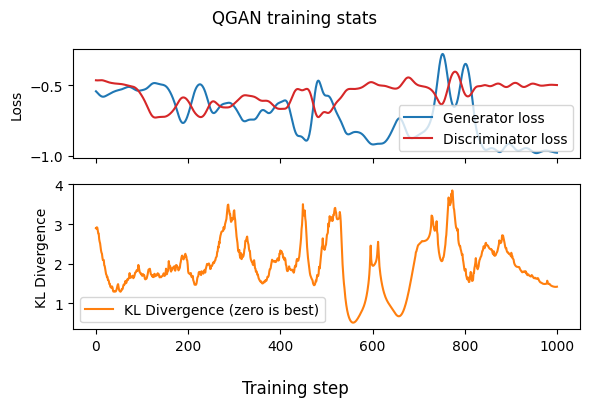

In [65]:
draw_results = 1
if draw_results:
        def prepare_loss_data(l): # For when C_STEPS > 1, implemented for creating less jobs in real hardware
                ax = [0]
                data =  [l[0]]
                for i in range(1, len(l)):
                        if l[i] != l[i - 1]:
                                ax.append(i)
                                data.append(l[i])
                return ax, data
        
        # Load saved data
        training_data_file, parameter_data_file, optimizers_data_folder = manage_files()
        current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params = initialize_parameters(0, training_data_file, parameter_data_file)

        gloss_ax, gloss_data = prepare_loss_data(gloss)
        dloss_ax, dloss_data = prepare_loss_data(dloss)

        fig, (loss, kl) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
        fig.suptitle('QGAN training stats')
        fig.supxlabel('Training step')
        loss.plot(gloss_ax, gloss_data, label="Generator loss")
        loss.plot(dloss_ax, dloss_data, label="Discriminator loss", color="C3")
        loss.legend()
        loss.set(ylabel='Loss')
        kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)", color="C1")
        kl.set(ylabel='KL Divergence')
        kl.legend()
        fig.tight_layout()

        print("Training complete:", training_data_file, "Results:", np.min(kl_div), "Improvement:", kl_div[0]-np.min(kl_div), np.argmin(kl_div))

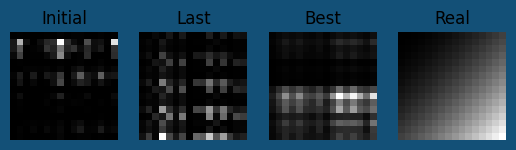

In [66]:
# Create test circuit with new parameters
draw_results = 1
if draw_results:
    if draw_prob:
        dict1 = Statevector(generator.assign_parameters(init_gen_params)).probabilities_dict()
        dict2 = Statevector(generator.assign_parameters(gen_params.numpy())).probabilities_dict()
        dict3 = Statevector(generator.assign_parameters(best_gen_params.numpy())).probabilities_dict()
        dict4 = Statevector(real_circuit).probabilities_dict()
        
        def prepare_dicts(dicts):
            for dict in dicts:
                for n in range(2**N_QUBITS):
                    key = format(n, 'b').zfill(N_QUBITS)
                    if key not in dict.keys():
                        dict[n] = 0.0
                    else:
                        dict[n] = dict[key]
                        del dict[key]
            

        prepare_dicts([dict1, dict2, dict3, dict4])

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=False, sharex=True, figsize=(16,4))
        ax1.set_title("Initial distribution")
        ax2.set_title("Last generated distribution")
        ax3.set_title("Best generated distribution")
        ax4.set_title("Real distribution")
        plot_histogram(dict1, ax=ax1)
        plot_histogram(dict2, ax=ax2)
        plot_histogram(dict3, ax=ax3)
        plot_histogram(dict4, ax=ax4)
        #fig.tight_layout()
        plt.show()

    
    probs1 = np.array(Statevector(generator.assign_parameters(init_gen_params)).probabilities()).reshape(dims)
    probs2 = np.array(Statevector(generator.assign_parameters(gen_params.numpy())).probabilities()).reshape(dims)
    probs3 = np.array(Statevector(generator.assign_parameters(best_gen_params.numpy())).probabilities()).reshape(dims)
    probs4 = np.array(Statevector(real_circuit).probabilities()).reshape(dims)

    plt.subplot(1,4,1)
    plt.imshow(probs1, cmap="gray")
    plt.axis("off")
    plt.title("Initial")
    
    plt.subplot(1,4,2)
    plt.imshow(probs2, cmap="gray")
    plt.axis("off")
    plt.title("Last")

    plt.subplot(1,4,3)
    plt.imshow(probs3, cmap="gray")
    plt.axis("off")
    plt.title("Best")

    plt.subplot(1,4,4)
    plt.imshow(probs4, cmap="gray")
    plt.axis("off")
    plt.title("Real")

    plt.gca().set_facecolor("#135077ff")

    # Optionally set the overall figure background to black
    plt.gcf().patch.set_facecolor("#135077ff")
    
    plt.show()